
Dataset: control
a = 7.177e-08 ± 1.272e-08
Deterministic k' = 3.065e+01
Monte Carlo result:
k' = 3.069e+01 +2.410e+01 -1.185e+01

Dataset: 10_fibrils
a = 6.492e-08 ± 2.294e-08
Deterministic k' = 4.141e+01
Monte Carlo result:
k' = 4.109e+01 +1.089e+02 -2.435e+01

Dataset: 30_fibrils
a = 8.820e-08 ± 1.613e-08
Deterministic k' = 1.651e+01
Monte Carlo result:
k' = 1.655e+01 +1.367e+01 -6.537e+00

Dataset: 10_monomar
a = 9.165e-08 ± 2.047e-08
Deterministic k' = 1.472e+01
Monte Carlo result:
k' = 1.472e+01 +1.654e+01 -6.651e+00

Dataset: 30_monomar
a = 1.149e-07 ± 8.647e-08
Deterministic k' = 7.473e+00
Monte Carlo result:
k' = 5.783e+00 +7.082e+01 -4.495e+00


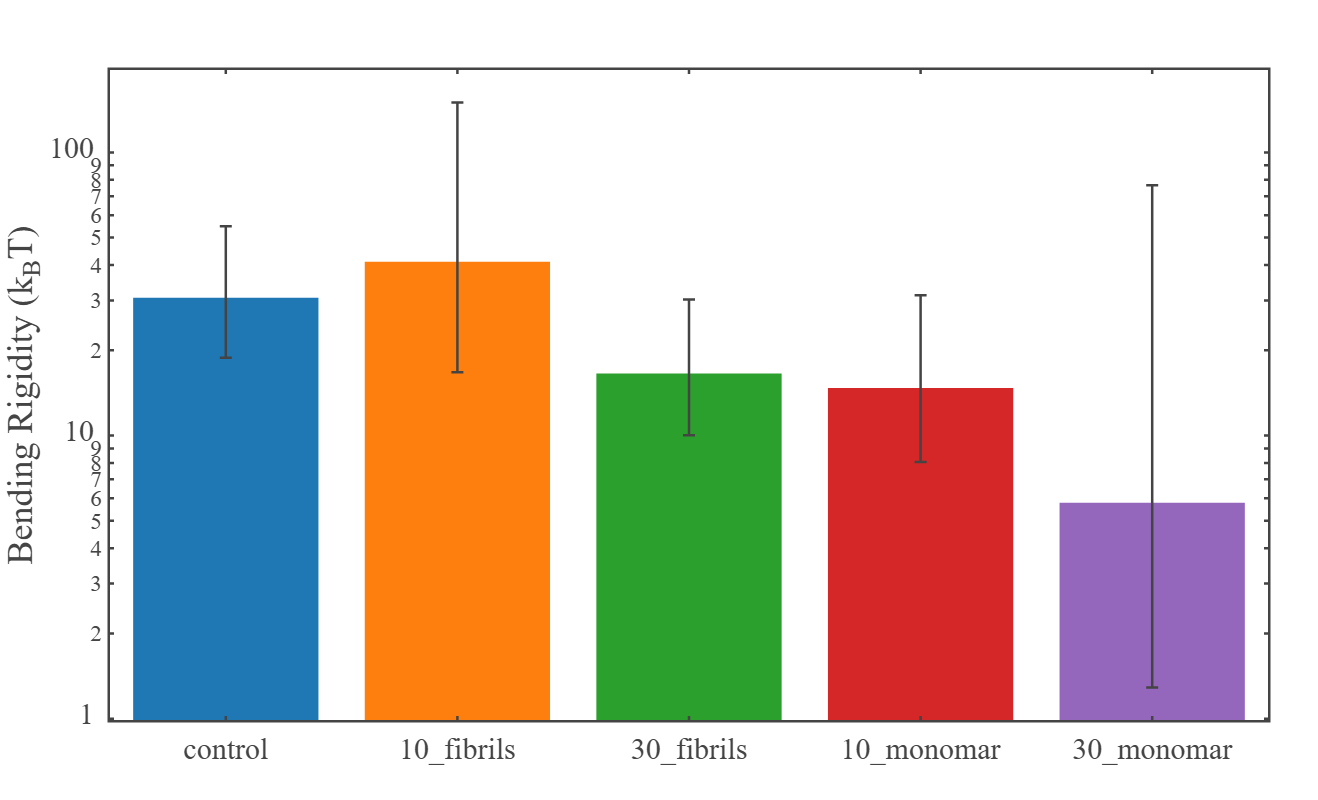

In [19]:
import numpy as np
import pandas as pd
import os
import plotly.graph_objects as go

# -------------------------------------------------
# Custom Plotly Template (provided by you)
# -------------------------------------------------
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    'xaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 4,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
    },
    'yaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 4,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
    },
    'font': {
        'family': 'mathjax',
        'size': 30,
    }
}

# -------------------------------------------------
# 1. Load data
# -------------------------------------------------
def load_data(file_path):
    data = pd.read_excel(file_path)
    return data["A"].values


# -------------------------------------------------
# 2. Unweighted mean and error
# -------------------------------------------------
def compute_unweighted_mean(values):
    N = len(values)
    mean = np.mean(values)
    std = np.std(values, ddof=1)
    error = std / np.sqrt(N)
    return mean, error


# -------------------------------------------------
# 3. Deterministic k'
# -------------------------------------------------
def compute_k_direct(a_mean, beta, k_J, k_kT):
    return k_J / (k_kT * beta**3 * a_mean**3)


# -------------------------------------------------
# 4. Monte Carlo propagation
# -------------------------------------------------
def monte_carlo_k(a_mean, a_error, beta, k_J, k_kT, N=300_000):

    a_samples = np.random.normal(a_mean, a_error, N)
    a_samples = a_samples[a_samples > 0]

    while len(a_samples) < N:
        extra = np.random.normal(a_mean, a_error, N - len(a_samples))
        extra = extra[extra > 0]
        a_samples = np.concatenate([a_samples, extra])

    a_samples = a_samples[:N]

    C = k_J / (k_kT * beta**3)
    k_samples = C / (a_samples**3)

    return k_samples


# -------------------------------------------------
# 5. Extract statistics
# -------------------------------------------------
def summarize_distribution(samples):
    median = np.median(samples)
    lower = np.percentile(samples, 16)
    upper = np.percentile(samples, 84)
    return median, lower, upper


# -------------------------------------------------
# 6. Process one dataset
# -------------------------------------------------
def process_dataset(file_path, beta, k_J, k_kT):

    name = os.path.basename(file_path).replace(".xlsx", "")
    print(f"\n==============================")
    print(f"Dataset: {name}")
    print(f"==============================")

    a_values = load_data(file_path)
    a_mean, a_error = compute_unweighted_mean(a_values)

    print(f"a = {a_mean:.3e} ± {a_error:.3e}")

    k_direct = compute_k_direct(a_mean, beta, k_J, k_kT)
    print(f"Deterministic k' = {k_direct:.3e}")

    k_samples = monte_carlo_k(a_mean, a_error, beta, k_J, k_kT)
    median, lower, upper = summarize_distribution(k_samples)

    print("Monte Carlo result:")
    print(f"k' = {median:.3e} +{upper - median:.3e} -{median - lower:.3e}")

    return name, k_samples


# -------------------------------------------------
# 7. Main
# -------------------------------------------------
def main():

    beta = 9.93e10
    k_J = 4.56e-8
    k_kT = 4.11e-21

    file_paths = [
        r"D:\Atanu\Narendran_GUV\Narendran_GUV\control.xlsx",
        r"D:\Atanu\Narendran_GUV\Narendran_GUV\10_fibrils.xlsx",
        r"D:\Atanu\Narendran_GUV\Narendran_GUV\30_fibrils.xlsx",
        r"D:\Atanu\Narendran_GUV\Narendran_GUV\10_monomar.xlsx",
        r"D:\Atanu\Narendran_GUV\Narendran_GUV\30_monomar.xlsx",
        
    ]

    all_samples = {}
    results = []

    # --- Compute results ---
    for path in file_paths:
        name, samples = process_dataset(path, beta, k_J, k_kT)
        all_samples[name] = samples

        # store summary for plotting
        median, lower, upper = summarize_distribution(samples)
        results.append((name, median, lower, upper))

    # --- Plot bar chart with asymmetric error bars ---
    names = [r[0] for r in results]
    medians = [r[1] for r in results]
    err_low = [r[1] - r[2] for r in results]
    err_high = [r[3] - r[1] for r in results]

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    fig = go.Figure()
    fig.add_trace(
        go.Bar(
            x=names,
            y=medians,
            error_y=dict(
                type='data',
                symmetric=False,
                array=err_high,
                arrayminus=err_low,
                thickness=2.5,
                width=6
            ),
            marker=dict(color=colors)
        )
    )

    fig.update_layout(
        template=fig_template,
        # xaxis_title="Dataset",
        width = 1100,
        height = 800,
        yaxis=dict(
            type="log",
            title="Bending Rigidity (k<sub>B</sub>T)"
        ),
        
        margin=dict(l=110, r=50, t=70, b=80),
    )

    fig.show()


# -------------------------------------------------
# Run
# -------------------------------------------------
if __name__ == "__main__":
    main()



Dataset: control
Idx |        A ± error            |        k' (median, 16–84%)         | w_up   w_lo
-----------------------------------------------------------------------------------------------
001 |  3.2888e-08 ± 3.56e-08        |  2.1610e+01  +4.01e+02  -1.78e+01     |  18.576  0.823
002 |  3.6900e-08 ± 1.59e-08        |  2.8929e+01  +1.17e+02  -1.89e+01     |  4.047  0.654
003 |  4.3100e-08 ± 2.47e-08        |  1.6855e+01  +1.23e+02  -1.22e+01     |  7.325  0.726

Average k' (linear average of medians):
k'_avg = 2.2465e+01
Average k' bounds (weighted-bound rule):
Upper: 2.4673e+02   (w_up_avg=9.9830)
Lower: 5.9716e+00   (w_lo_avg=0.7342)
Asymmetric: +2.24e+02  -1.65e+01

Dataset: 10_fibrils
Idx |        A ± error            |        k' (median, 16–84%)         | w_up   w_lo
-----------------------------------------------------------------------------------------------
001 |  2.2870e-08 ± 2.26e-08        |  7.1737e+01  +1.22e+03  -5.83e+01     |  16.976  0.813
002 |  1.0182e-07 

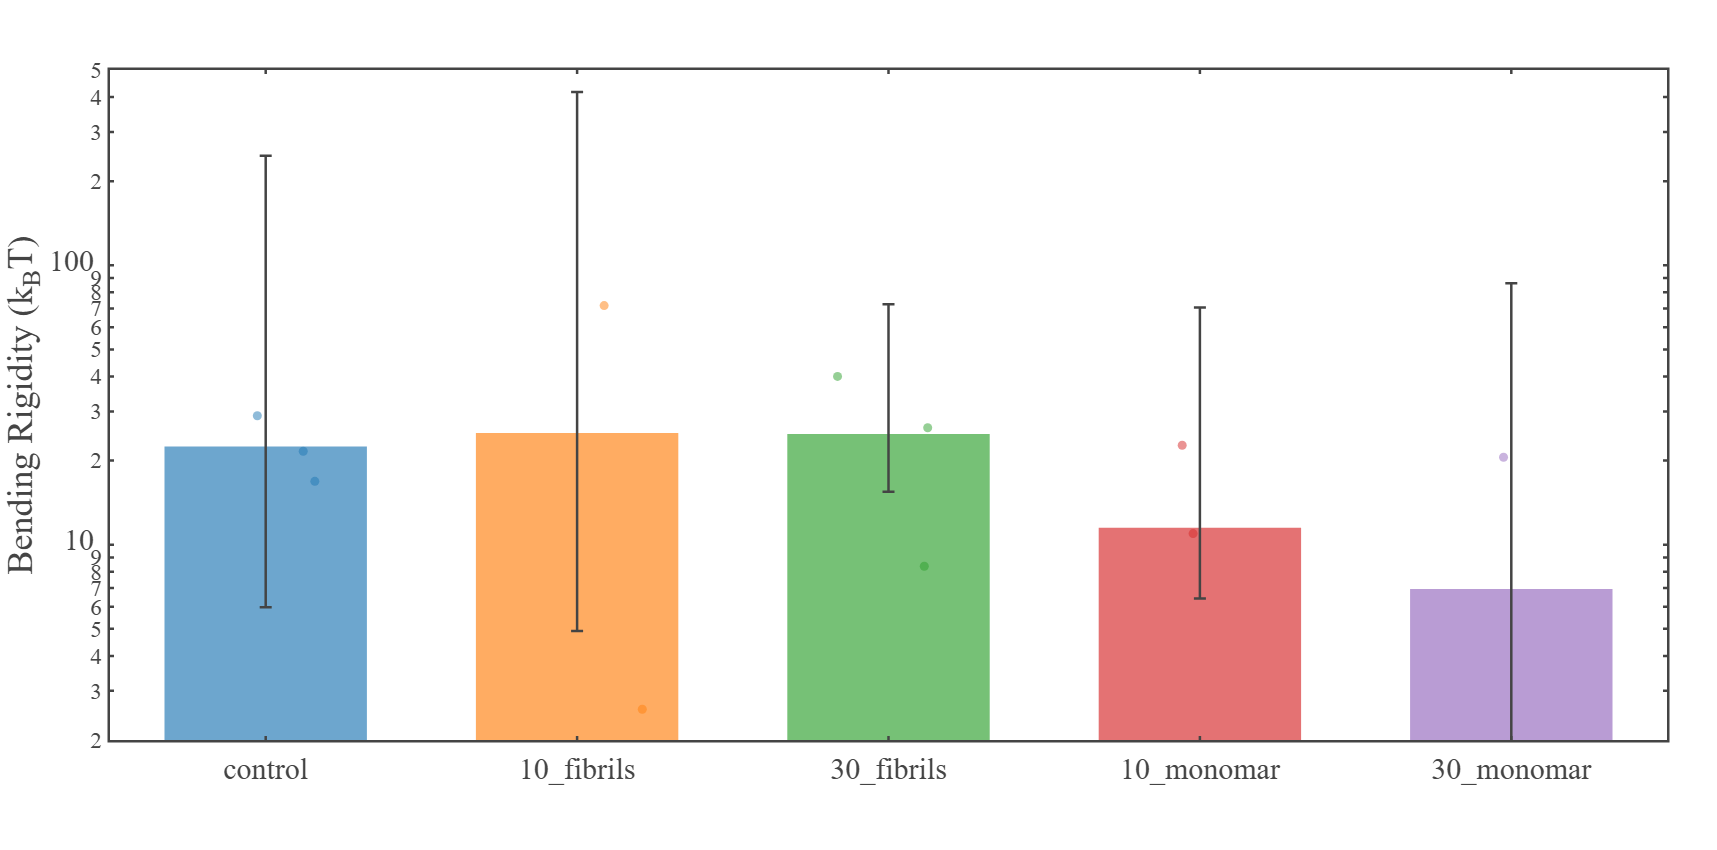

In [123]:
import numpy as np
import pandas as pd
import os
import plotly.graph_objects as go

# -------------------------------------------------
# Custom Plotly Template (provided by you)
# -------------------------------------------------
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    'xaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 4,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
    },
    'yaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 4,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
    },
    'font': {
        'family': 'mathjax',
        'size': 30,
    }
}

# -------------------------------------------------
# Monte Carlo settings
# -------------------------------------------------
N_MC = 300_000
rng = np.random.default_rng(42)

A_COL = "A"
ERR_COL = "error"

# -------------------------------------------------
# 1. Load data (A and error)
# -------------------------------------------------
def load_data_with_error(file_path, a_col=A_COL, err_col=ERR_COL):
    df = pd.read_excel(file_path)

    if a_col not in df.columns or err_col not in df.columns:
        raise KeyError(
            f"Need columns '{a_col}' and '{err_col}' in {file_path}. Found: {list(df.columns)}"
        )

    df[a_col] = pd.to_numeric(df[a_col], errors="coerce")
    df[err_col] = pd.to_numeric(df[err_col], errors="coerce")

    df = df.dropna(subset=[a_col, err_col])
    df = df[(df[a_col] > 0) & (df[err_col] >= 0)]

    return df[a_col].to_numpy(dtype=float), df[err_col].to_numpy(dtype=float)


# -------------------------------------------------
# 2. Monte Carlo for one membrane: A ± error -> k samples
# -------------------------------------------------
def mc_k_from_a(a, sigma_a, C, N=N_MC):
    if sigma_a == 0 or np.isclose(sigma_a, 0):
        k = C / (a**3)
        return np.full(N, k, dtype=float)

    a_s = rng.normal(a, sigma_a, size=N)
    a_s = a_s[a_s > 0]

    while a_s.size < N:
        extra = rng.normal(a, sigma_a, size=N - a_s.size)
        extra = extra[extra > 0]
        a_s = np.concatenate([a_s, extra])

    a_s = a_s[:N]
    return C / (a_s**3)


# -------------------------------------------------
# 3. Summary: median + 16–84% (asymmetric)
# -------------------------------------------------
def summarize(samples):
    med = np.median(samples)
    p16 = np.percentile(samples, 16)
    p84 = np.percentile(samples, 84)
    return med, p16, p84


# -------------------------------------------------
# 4. Process one dataset using YOUR weighted-bound rule
#    - Per membrane: MC -> (med, p16, p84)
#    - Average k: linear average of the 3 medians
#    - Average bounds:
#         w_up_i = (p84_i - med_i)/med_i
#         w_lo_i = (med_i - p16_i)/med_i
#         w_up_avg = mean(w_up_i), w_lo_avg = mean(w_lo_i)
#         kavg_upper = kavg * (1 + w_up_avg)
#         kavg_lower = kavg * (1 - w_lo_avg)
# -------------------------------------------------
def process_dataset_weighted_bounds(file_path, beta, k_J, k_kT):
    name = os.path.basename(file_path).replace(".xlsx", "")

    a_vals, sig_vals = load_data_with_error(file_path, A_COL, ERR_COL)

    C = k_J / (k_kT * beta**3)

    k_med_list, k_p16_list, k_p84_list = [], [], []
    w_up_list, w_lo_list = [], []

    # Print side-by-side
    print(f"\n==============================")
    print(f"Dataset: {name}")
    print(f"==============================")
    print("Idx |        A ± error            |        k' (median, 16–84%)         | w_up   w_lo")
    print("-"*95)

    for i, (a, s) in enumerate(zip(a_vals, sig_vals), start=1):
        ks = mc_k_from_a(a, s, C, N=N_MC)
        k_med, k_p16, k_p84 = summarize(ks)

        # normalized bounds relative to median
        w_up = (k_p84 - k_med) / k_med if k_med > 0 else np.nan
        w_lo = (k_med - k_p16) / k_med if k_med > 0 else np.nan

        k_med_list.append(k_med)
        k_p16_list.append(k_p16)
        k_p84_list.append(k_p84)
        w_up_list.append(w_up)
        w_lo_list.append(w_lo)

        print(
            f"{i:03d} | {a: .4e} ± {s:.2e}        | "
            f"{k_med: .4e}  +{(k_p84-k_med):.2e}  -{(k_med-k_p16):.2e}     | "
            f"{w_up: .3f} {w_lo: .3f}"
        )

    k_med_arr = np.array(k_med_list, dtype=float)
    w_up_arr = np.array(w_up_list, dtype=float)
    w_lo_arr = np.array(w_lo_list, dtype=float)

    # Average k by linear average of medians
    kavg = float(np.mean(k_med_arr))

    # Average the relative bounds
    w_up_avg = float(np.nanmean(w_up_arr))
    w_lo_avg = float(np.nanmean(w_lo_arr))

    # Bounds for average k
    kavg_upper = kavg * (1.0 + w_up_avg)
    kavg_lower = kavg * (1.0 - w_lo_avg)

    print("\nAverage k' (linear average of medians):")
    print(f"k'_avg = {kavg:.4e}")
    print("Average k' bounds (weighted-bound rule):")
    print(f"Upper: {kavg_upper:.4e}   (w_up_avg={w_up_avg:.4f})")
    print(f"Lower: {kavg_lower:.4e}   (w_lo_avg={w_lo_avg:.4f})")
    print(f"Asymmetric: +{(kavg_upper-kavg):.2e}  -{(kavg-kavg_lower):.2e}")

    # For plotting strip: per-membrane k medians
    # For plotting bar: average k and its bounds
    return name, k_med_arr, (kavg, kavg_lower, kavg_upper)


# -------------------------------------------------
# 5. Main
# -------------------------------------------------
def main():

    beta = 1.96e11
    k_J = 4.56e-8
    k_kT = 4.11e-21

    file_paths = [
        r"D:\Atanu\Narendran_GUV\Narendran_GUV\control.xlsx",
        r"D:\Atanu\Narendran_GUV\Narendran_GUV\10_fibrils.xlsx",
        r"D:\Atanu\Narendran_GUV\Narendran_GUV\30_fibrils.xlsx",
        r"D:\Atanu\Narendran_GUV\Narendran_GUV\10_monomar.xlsx",
        r"D:\Atanu\Narendran_GUV\Narendran_GUV\30_monomar.xlsx",
    ]

    results = []
    all_k_points = {}  # per-membrane medians

    for path in file_paths:
        name, k_medians_per_membrane, (kavg, kavg_lower, kavg_upper) = process_dataset_weighted_bounds(
            path, beta, k_J, k_kT
        )
        all_k_points[name] = k_medians_per_membrane
        results.append((name, kavg, kavg_lower, kavg_upper))

    # -------------------------------------------------
    # Plot: per-membrane strip + average bar with weighted-bound error bars
    # -------------------------------------------------
    names = [r[0] for r in results]
    centers = [r[1] for r in results]
    err_low = [r[1] - r[2] for r in results]   # center - lower
    err_high = [r[3] - r[1] for r in results]  # upper - center

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    color_map = {n: colors[i % len(colors)] for i, n in enumerate(names)}

    rng_plot = np.random.default_rng(42)
    jitter_width = 0.22

    fig = go.Figure()

    # 1) Per-membrane points: per-membrane k medians
    for i, n in enumerate(names):
        k_vals = all_k_points[n]
        x_jitter = rng_plot.uniform(-jitter_width, jitter_width, size=len(k_vals))
        x = i + x_jitter

        fig.add_trace(
            go.Scatter(
                x=x,
                y=k_vals,
                mode="markers",
                marker=dict(size=9, opacity=0.5, color=color_map[n], line=dict(width=0)),
                hovertemplate=(f"<b>{n}</b><br>k'=%{{y:.3e}}<extra></extra>"),
                showlegend=False
            )
        )

    # 2) Average bars with weighted-bound rule error bars
    fig.add_trace(
        go.Bar(
            x=list(range(len(names))),
            y=centers,
            error_y=dict(
                type='data',
                symmetric=False,
                array=err_high,
                arrayminus=err_low,
                thickness=2.5,
                width=6
            ),
            marker=dict(color=[color_map[n] for n in names], opacity=0.65),
            customdata=names,
            hovertemplate=(
                "<b>%{customdata}</b><br>"
                "k'_avg=%{y:.3e}<br>"
                "+err=%{error_y.array:.3e}<br>"
                "-err=%{error_y.arrayminus:.3e}<extra></extra>"
            ),
            showlegend=False,
        )
    )

    fig.update_layout(
        template=fig_template,
        width=1200,
        height=850,
        yaxis=dict(
            type="log",
            range=[np.log10(2), np.log10(500)],
            title="Bending Rigidity (k<sub>B</sub>T)"
        ),
        xaxis=dict(
            tickmode="array",
            tickvals=list(range(len(names))),
            ticktext=names,
        ),
        margin=dict(l=110, r=50, t=70, b=110),
        bargap=0.35
    )

    fig.show()


if __name__ == "__main__":
    main()


In [114]:
# =========================
# Per-membrane k (MC median, 16–84) from (A ± error),
# then average k by linear averaging of the 3 medians,
# and compute avg-k bounds using your "weighted bound" rule.
#
# ADDITION:
# Statistical significance vs CONTROL using Monte Carlo distributions:
# - build k_avg_samples for each dataset as mean of k_i^(j) across membranes (per MC draw)
# - compare treatment vs control:
#     p_greater = P(k_treat > k_control)
#     two_sided_p = 2*min(p_greater, 1-p_greater)
# - also report median difference and 16–84% interval of the difference distribution
# =========================
import numpy as np
import pandas as pd
import os

# Constants
beta = 1.96e11
k_J = 4.56e-8
k_kT = 4.11e-21
C = k_J / (k_kT * beta**3)

file_paths = [
    r"D:\Atanu\Narendran_GUV\Narendran_GUV\control.xlsx",
    r"D:\Atanu\Narendran_GUV\Narendran_GUV\10_fibrils.xlsx",
    r"D:\Atanu\Narendran_GUV\Narendran_GUV\30_fibrils.xlsx",
    r"D:\Atanu\Narendran_GUV\Narendran_GUV\10_monomar.xlsx",
    r"D:\Atanu\Narendran_GUV\Narendran_GUV\30_monomar.xlsx",
]

A_COL = "A"
ERR_COL = "error"

N_MC = 300_000
rng = np.random.default_rng(42)

def mc_k_from_a(a, sigma_a, C, N=N_MC):
    """Sample A ~ N(a, sigma_a) truncated to >0; compute k = C/A^3."""
    if sigma_a == 0 or np.isclose(sigma_a, 0):
        k = C / (a**3)
        return np.full(N, k, dtype=float)

    a_s = rng.normal(a, sigma_a, size=N)
    a_s = a_s[a_s > 0]

    while a_s.size < N:
        extra = rng.normal(a, sigma_a, size=N - a_s.size)
        extra = extra[extra > 0]
        a_s = np.concatenate([a_s, extra])

    a_s = a_s[:N]
    return C / (a_s**3)

def summarize(samples):
    """median + 16/84 percentiles."""
    med = np.median(samples)
    p16 = np.percentile(samples, 16)
    p84 = np.percentile(samples, 84)
    return med, p16, p84

def load_clean(file_path):
    df = pd.read_excel(file_path)
    df[A_COL] = pd.to_numeric(df[A_COL], errors="coerce")
    df[ERR_COL] = pd.to_numeric(df[ERR_COL], errors="coerce")
    df = df.dropna(subset=[A_COL, ERR_COL])
    df = df[(df[A_COL] > 0) & (df[ERR_COL] >= 0)]
    return df

def mc_kavg_samples(a_vals, sig_vals, C, N=N_MC):
    """
    MC distribution of the linear-average k across membranes:
      k_avg^(j) = mean_i k_i^(j)
    """
    k_samples_list = [mc_k_from_a(a, s, C, N=N) for a, s in zip(a_vals, sig_vals)]
    k_stack = np.vstack(k_samples_list)      # (n_membranes, N)
    return np.mean(k_stack, axis=0)          # (N,)

# ---- store MC-average distributions for significance testing
kavg_samples_by_name = {}

for file_path in file_paths:
    name = os.path.basename(file_path).replace(".xlsx", "")
    print("\n" + "="*110)
    print(name)
    print("="*110)

    df = load_clean(file_path)
    if len(df) == 0:
        print("[ERROR] No valid rows with A>0 and error>=0.")
        continue

    a_vals = df[A_COL].to_numpy(dtype=float)
    sig_vals = df[ERR_COL].to_numpy(dtype=float)

    # Per-membrane summaries + your weighted-bound rule ingredients
    k_med_list, k_p16_list, k_p84_list = [], [], []
    w_up_list, w_lo_list = [], []

    print("\nIdx |        A ± error            |        k' (median, 16–84%)         | w_up   w_lo")
    print("-"*110)

    for i, (a, s) in enumerate(zip(a_vals, sig_vals), start=1):
        ks = mc_k_from_a(a, s, C, N=N_MC)
        k_med, k_p16, k_p84 = summarize(ks)

        w_up = (k_p84 - k_med) / k_med if k_med > 0 else np.nan
        w_lo = (k_med - k_p16) / k_med if k_med > 0 else np.nan

        k_med_list.append(k_med)
        k_p16_list.append(k_p16)
        k_p84_list.append(k_p84)
        w_up_list.append(w_up)
        w_lo_list.append(w_lo)

        print(
            f"{i:03d} | {a: .4e} ± {s:.2e}        | "
            f"{k_med: .4e} +{(k_p84-k_med):.2e} -{(k_med-k_p16):.2e}     | "
            f"{w_up: .3f} {w_lo: .3f}"
        )

    k_med_arr = np.array(k_med_list, dtype=float)
    w_up_arr = np.array(w_up_list, dtype=float)
    w_lo_arr = np.array(w_lo_list, dtype=float)

    # Your average k: linear average of the three medians
    kavg = float(np.mean(k_med_arr))

    # Your weighted bounds
    w_up_avg = float(np.nanmean(w_up_arr))
    w_lo_avg = float(np.nanmean(w_lo_arr))
    kavg_upper = kavg * (1.0 + w_up_avg)
    kavg_lower = kavg * (1.0 - w_lo_avg)

    print("\nAverage k' (linear average of the three medians):")
    print(f"k'_avg = {kavg:.4e}")
    print("\nAverage k' bounds (your weighted-bound rule):")
    print(f"Upper: {kavg_upper:.4e}   (w_up_avg={w_up_avg:.4f})")
    print(f"Lower: {kavg_lower:.4e}   (w_lo_avg={w_lo_avg:.4f})")
    print(f"Asymmetric: +{(kavg_upper-kavg):.2e}  -{(kavg-kavg_lower):.2e}")

    # For significance testing: MC distribution of average k (per-draw linear mean)
    kavg_samples_by_name[name] = mc_kavg_samples(a_vals, sig_vals, C, N=N_MC)

# =========================
# Statistical significance vs CONTROL
# =========================
def compare_to_control(treat_samples, control_samples):
    """
    Monte Carlo 'probability of superiority' + two-sided p-value analogue:
      p_greater = P(treat > control)
      p_two     = 2*min(p_greater, 1-p_greater)
    Also returns difference distribution summary.
    """
    # Independent draws: pair by index (same N) is fine for MC estimation
    n = min(len(treat_samples), len(control_samples))
    t = treat_samples[:n]
    c = control_samples[:n]

    diff = t - c
    diff_med, diff_p16, diff_p84 = summarize(diff)

    p_greater = float(np.mean(t > c))
    p_two = 2.0 * min(p_greater, 1.0 - p_greater)

    # ratio can be useful too
    ratio = t / c
    r_med, r_p16, r_p84 = summarize(ratio)

    return {
        "p_greater": p_greater,
        "p_two_sided": p_two,
        "diff_med": diff_med, "diff_p16": diff_p16, "diff_p84": diff_p84,
        "ratio_med": r_med, "ratio_p16": r_p16, "ratio_p84": r_p84
    }

# Find control key
control_key = None
for k in kavg_samples_by_name.keys():
    if k.lower() == "control":
        control_key = k
        break

print("\n" + "="*110)
print("Significance vs Control (Monte Carlo comparison on k_avg distributions)")
print("="*110)

if control_key is None:
    print("[ERROR] Control dataset not found (expected file name 'control.xlsx').")
else:
    control_samples = kavg_samples_by_name[control_key]

    # Compare monomars and fibrils to control
    for name, treat_samples in kavg_samples_by_name.items():
        if name == control_key:
            continue

        lname = name.lower()
        if ("monomar" in lname) or ("fibrils" in lname) or ("fibril" in lname):
            res = compare_to_control(treat_samples, control_samples)

            print(f"\n{name} vs {control_key}")
            print(f"P(k_treat > k_control) = {res['p_greater']:.4f}")
            print(f"Two-sided p (MC)        = {res['p_two_sided']:.4f}")
            print(f"Δk = treat-control (median, 16–84%): "
                  f"{res['diff_med']:.3e}  [{res['diff_p16']:.3e}, {res['diff_p84']:.3e}]")
            print(f"Ratio treat/control (median, 16–84%): "
                  f"{res['ratio_med']:.3e}  [{res['ratio_p16']:.3e}, {res['ratio_p84']:.3e}]")



control

Idx |        A ± error            |        k' (median, 16–84%)         | w_up   w_lo
--------------------------------------------------------------------------------------------------------------
001 |  3.2888e-08 ± 3.56e-08        |  2.1610e+01 +4.01e+02 -1.78e+01     |  18.576  0.823
002 |  3.6900e-08 ± 1.59e-08        |  2.8929e+01 +1.17e+02 -1.89e+01     |  4.047  0.654
003 |  4.3100e-08 ± 2.47e-08        |  1.6855e+01 +1.23e+02 -1.22e+01     |  7.325  0.726

Average k' (linear average of the three medians):
k'_avg = 2.2465e+01

Average k' bounds (your weighted-bound rule):
Upper: 2.4673e+02   (w_up_avg=9.9830)
Lower: 5.9716e+00   (w_lo_avg=0.7342)
Asymmetric: +2.24e+02  -1.65e+01

10_fibrils

Idx |        A ± error            |        k' (median, 16–84%)         | w_up   w_lo
--------------------------------------------------------------------------------------------------------------
001 |  2.2870e-08 ± 2.26e-08        |  7.1988e+01 +1.24e+03 -5.85e+01     |  17.201  0.

In [115]:
# =========================
# Tukey HSD significance test (per-membrane k medians)
# =========================
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd

# Collect per-membrane median k values for all groups
group_labels = []
k_values_all = []

for file_path in file_paths:
    name = os.path.basename(file_path).replace(".xlsx", "")
    df = pd.read_excel(file_path)
    df[A_COL] = pd.to_numeric(df[A_COL], errors="coerce")
    df[ERR_COL] = pd.to_numeric(df[ERR_COL], errors="coerce")
    df = df.dropna(subset=[A_COL, ERR_COL])
    df = df[(df[A_COL] > 0) & (df[ERR_COL] >= 0)]

    if len(df) == 0:
        continue

    a_vals = df[A_COL].to_numpy(dtype=float)
    sig_vals = df[ERR_COL].to_numpy(dtype=float)

    # Per-membrane median k (from MC)
    for a, s in zip(a_vals, sig_vals):
        ks = mc_k_from_a(a, s, C, N=N_MC)
        k_med, _, _ = summarize(ks)

        k_values_all.append(k_med)
        group_labels.append(name)

# Convert to dataframe
data_tukey = pd.DataFrame({
    "k": k_values_all,
    "group": group_labels
})

# Perform Tukey HSD
tukey = pairwise_tukeyhsd(endog=data_tukey["k"],
                          groups=data_tukey["group"],
                          alpha=0.05)

print("\n" + "="*100)
print("Tukey HSD Results")
print("="*100)
print(tukey.summary())


# =========================
# Convert p-values to stars
# =========================
def significance_stars(p):
    if p < 0.0001:
        return "****"
    elif p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

print("\nPairwise significance (stars):\n")

for res in tukey.summary().data[1:]:
    g1, g2, meandiff, p_adj, lower, upper, reject = res
    stars = significance_stars(float(p_adj))
    print(f"{g1} vs {g2}:  p={float(p_adj):.4e}   {stars}")



Tukey HSD Results
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2   meandiff p-adj   lower    upper  reject
-------------------------------------------------------------
10_fibrils 10_monomar -13.6401 0.9246 -69.7098 42.4297  False
10_fibrils 30_fibrils  -0.2786    1.0 -56.3483 55.7911  False
10_fibrils 30_monomar -18.1911 0.8186 -74.2608 37.8786  False
10_fibrils    control  -2.7154 0.9998 -58.7852 53.3543  False
10_monomar 30_fibrils  13.3615 0.9295 -42.7082 69.4312  False
10_monomar 30_monomar   -4.551 0.9987 -60.6207 51.5187  False
10_monomar    control  10.9246 0.9645 -45.1451 66.9944  False
30_fibrils 30_monomar -17.9125 0.8263 -73.9822 38.1572  False
30_fibrils    control  -2.4369 0.9999 -58.5066 53.6329  False
30_monomar    control  15.4757 0.8874 -40.5941 71.5454  False
-------------------------------------------------------------

Pairwise significance (stars):

10_fibrils vs 10_monomar:  p=9.2460e-01   ns
10_fibrils vs 30_fibrils:  p=1.0000